In [1]:
import xml.etree.cElementTree as et
import pandas as pd
import numpy as np
import requests

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.debugger import set_trace
#from statsmodels.stats.proportion import proportion_ztest

# Step 1: Acquire Data From CSV File

In [2]:
beach_complete = pd.read_csv('beach_complete.csv',delimiter=',',header=0,index_col=0)

In [3]:
beach_clean = beach_complete.dropna()

In [4]:
beach_clean.apply(pd.to_numeric);

In [5]:
beach_clean['average'] = beach_clean.mean(1)

/home/rkumar/anaconda3/envs/DS1ENV/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
beach_clean.head(10)

,MCurtis-1,Bluffers-10,Rouge-11,Sunnyside-2,Hanlans-3,Gibraltar-4,Centre-5,Wards-6,Cherry-7,Woodbine-8,KewBalmy-9,average
sampleDate,,,,,,,,,,,,
2009-06-01,27.0,12.0,39.0,28.0,11.0,18.0,24.0,63.0,51.0,10.0,10.0,26.636364
2009-06-02,10.0,14.0,52.0,16.0,10.0,18.0,22.0,18.0,19.0,10.0,10.0,18.090909
2009-06-03,22.0,11.0,14.0,10.0,10.0,11.0,14.0,10.0,10.0,10.0,10.0,12.000000
2009-06-04,26.0,10.0,11.0,10.0,10.0,11.0,11.0,10.0,10.0,10.0,10.0,11.727273
2009-06-05,35.0,10.0,31.0,11.0,10.0,10.0,10.0,12.0,10.0,10.0,10.0,14.454545
2009-06-06,133.0,13.0,29.0,18.0,12.0,10.0,12.0,16.0,10.0,12.0,10.0,25.000000
2009-06-07,604.0,16.0,20.0,97.0,37.0,28.0,41.0,47.0,10.0,12.0,11.0,83.909091
2009-06-08,405.0,17.0,99.0,142.0,31.0,33.0,43.0,39.0,10.0,10.0,12.0,76.454545
2009-06-10,170.0,25.0,155.0,26.0,11.0,18.0,21.0,11.0,12.0,18.0,31.0,45.272727


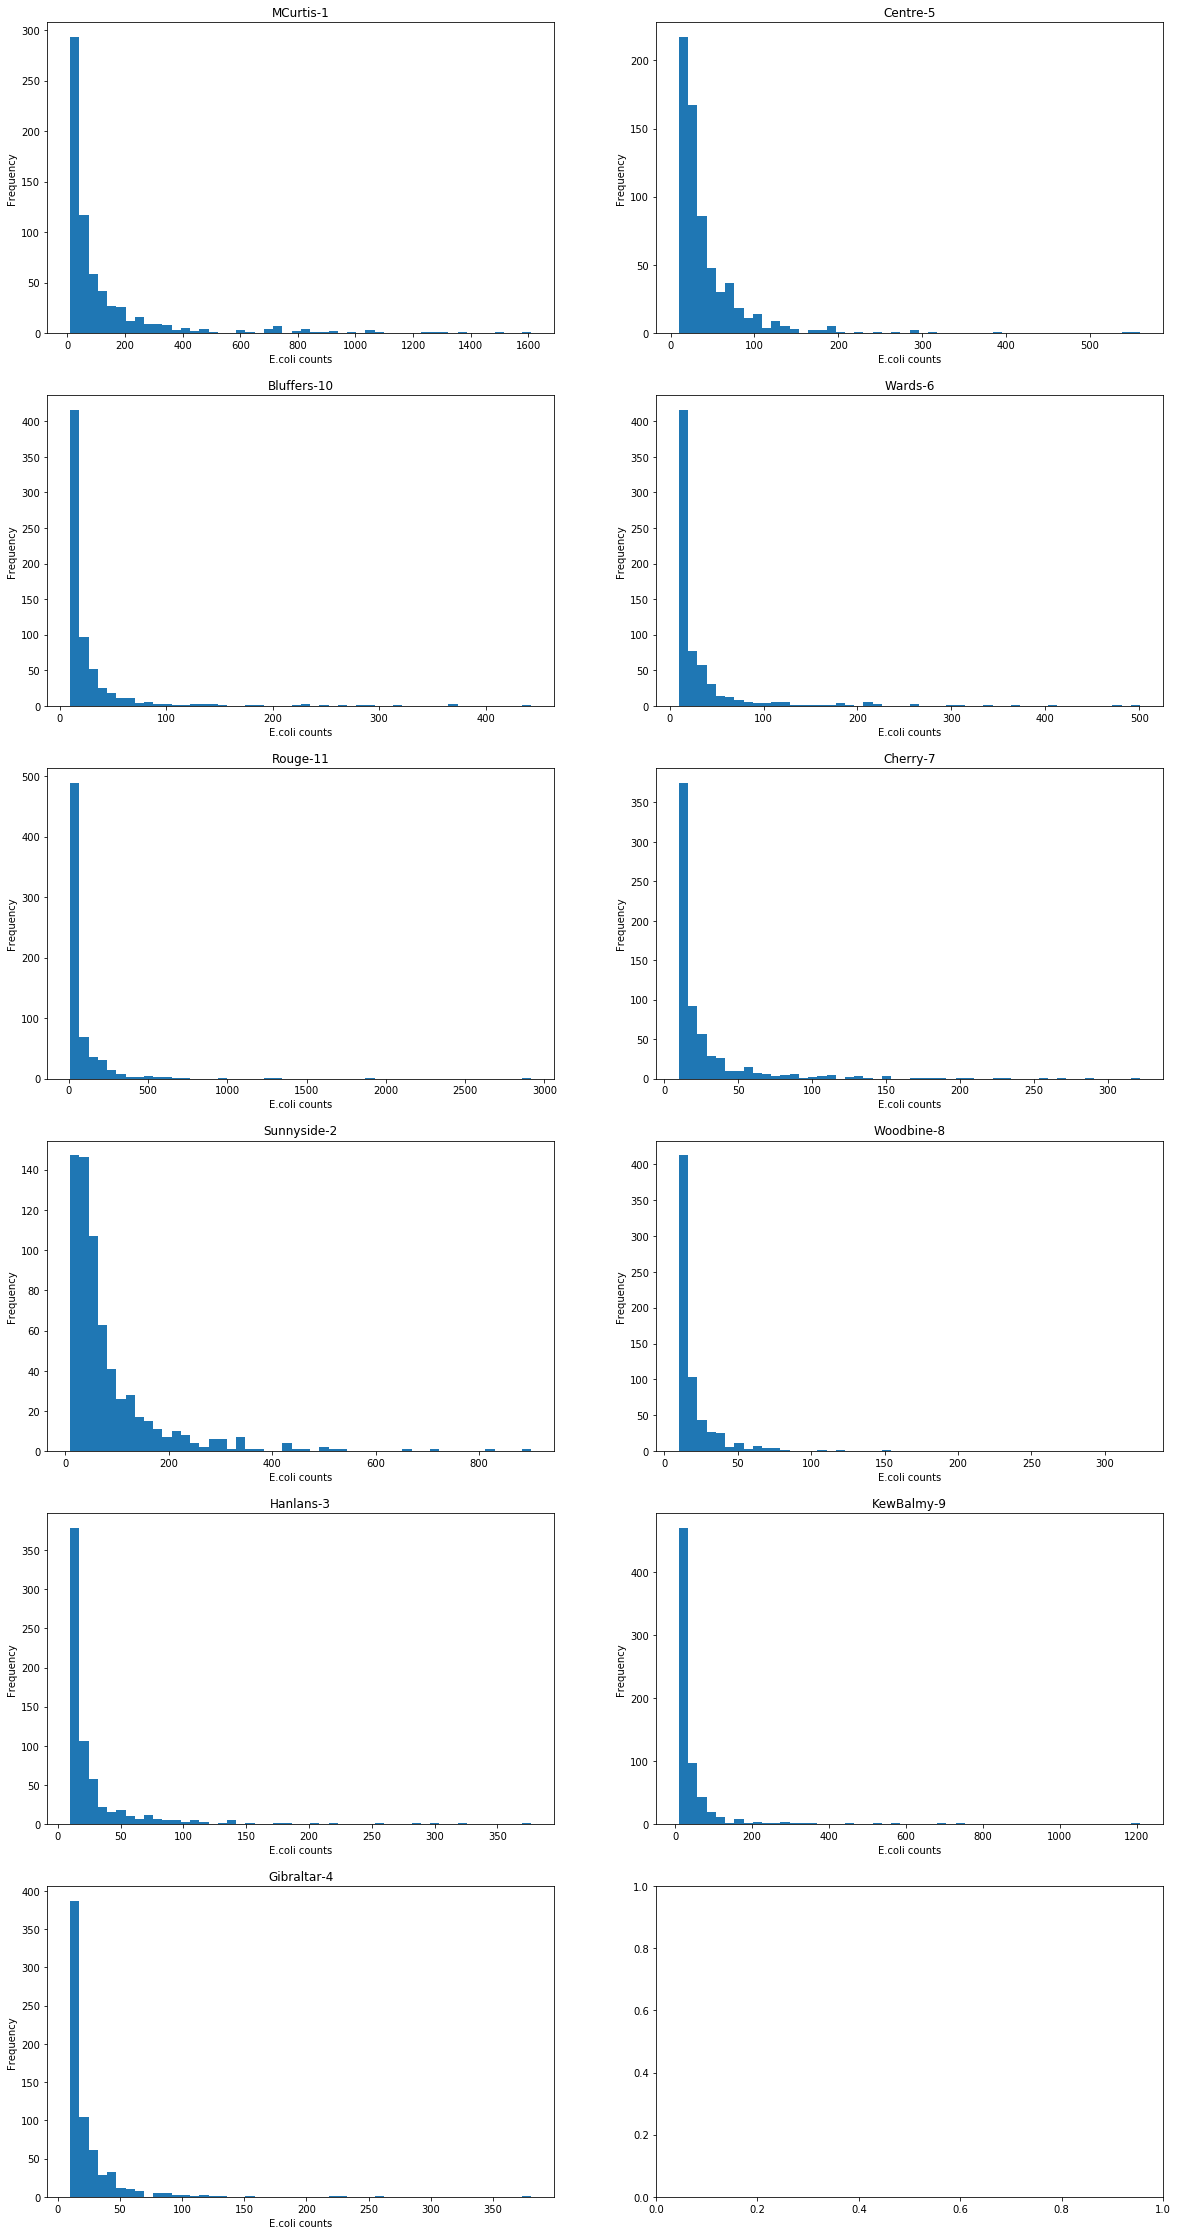

In [7]:
fig, ax = plt.subplots(6, 2, figsize=(20,40))
cols = beach_clean.columns
for i in range(6):
    for j in range(2):
        if j == 1 and i == 5:
            break
        elif j == 0:
            ax[i][j].hist(beach_clean[cols[i]].values, bins=50, histtype='stepfilled')
            ax[i][j].set(xlabel='E.coli counts',ylabel='Frequency',title=cols[i])
            #set_trace()
        else:
            ax[i][j].hist(beach_clean[cols[i+6]].values, bins=50, histtype='stepfilled')
            ax[i][j].set(xlabel='E.coli counts',ylabel='Frequency',title=cols[i+6])

In [8]:
sunnyside = beach_clean[['Sunnyside-2']]

In [9]:
sunnyside.info()

<class 'pandas.core.frame.DataFrame'>
Index: 668 entries, 2009-06-01 to 2018-09-03
Data columns (total 1 columns):
Sunnyside-2    668 non-null float64
dtypes: float64(1)
memory usage: 10.4+ KB


In [10]:
sunnyside.head()

,Sunnyside-2
sampleDate,
2009-06-01,28.0
2009-06-02,16.0
2009-06-03,10.0
2009-06-04,10.0
2009-06-05,11.0


In [11]:
sunnyside = sunnyside.reset_index()

In [12]:
sunnyside.head()

,sampleDate,Sunnyside-2
0,2009-06-01,28.0
1,2009-06-02,16.0
2,2009-06-03,10.0
3,2009-06-04,10.0
4,2009-06-05,11.0


In [13]:
centre = beach_clean[['Centre-5']]

In [14]:
centre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 668 entries, 2009-06-01 to 2018-09-03
Data columns (total 1 columns):
Centre-5    668 non-null float64
dtypes: float64(1)
memory usage: 10.4+ KB


In [15]:
centre.head()

,Centre-5
sampleDate,
2009-06-01,24.0
2009-06-02,22.0
2009-06-03,14.0
2009-06-04,11.0
2009-06-05,10.0


In [16]:
centre = centre.reset_index()

In [17]:
centre.head()

,sampleDate,Centre-5
0,2009-06-01,24.0
1,2009-06-02,22.0
2,2009-06-03,14.0
3,2009-06-04,11.0
4,2009-06-05,10.0


# Step 2: ACF and PACF plots

In [18]:
# def plot_acf_pacf(list_tuples):
#     fig, ax = plt.subplots(11, 2, figsize=(20,40))
#     for i in range(len(list_tuples)):
#         for j in range(len(list_tuples[i])-1):
#             str_title_acf = "Autocorrelation " + list_tuples[i][1]
#             str_title_pacf = "Partial Autocorrelation  " + list_tuples[i][1]
#             plot_acf(list_tuples[i][0], lags=50, title=str_title_acf, ax=ax[i][j])
#             plot_pacf(list_tuples[i][0], lags=50, title=str_title_pacf, ax=ax[i][j+1])
    
#     plt.show();

# plot_acf_pacf(list_tuples)

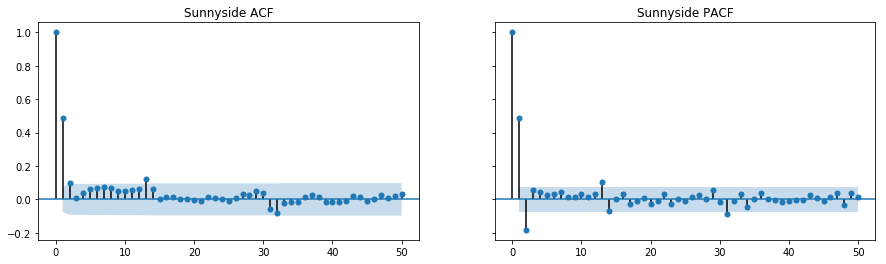

In [19]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,4))
plot_acf(sunnyside['Sunnyside-2'], lags=50, title='Sunnyside ACF', ax=ax[0])
plot_pacf(sunnyside['Sunnyside-2'], lags=50, title='Sunnyside PACF', ax=ax[1])
plt.show();

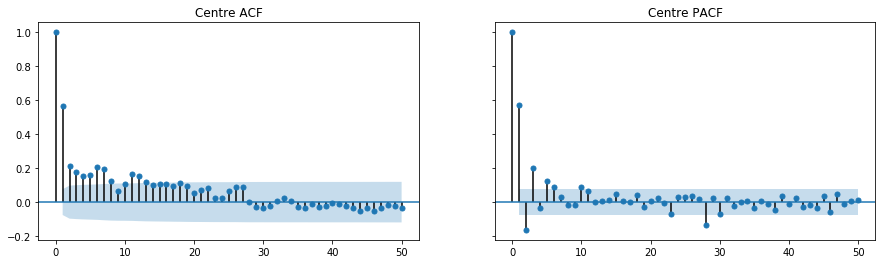

In [20]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,4))
plot_acf(centre['Centre-5'], lags=50, title='Centre ACF', ax=ax[0])
plot_pacf(centre['Centre-5'], lags=50, title='Centre PACF', ax=ax[1])
plt.show();

For all 11 beaches, it seems that with a lag=6 there will be very little partial correlation. So we assume lag=6 for both our AR and MA parameters for now.

# Step 3: Setup Train and Test

In [21]:
train_size = int(0.7 * sunnyside['Sunnyside-2'].size)
test_size = int(0.3 * sunnyside['Sunnyside-2'].size)

In [22]:
train_size, test_size

(467, 200)

In [23]:
sunnyside['Label'] = 0
for i in sunnyside.index:
    if i >= train_size:
        sunnyside.loc[i, 'Label'] = 1

In [24]:
sunnyside.head(), sunnyside.tail()

(   sampleDate  Sunnyside-2  Label
 0  2009-06-01         28.0      0
 1  2009-06-02         16.0      0
 2  2009-06-03         10.0      0
 3  2009-06-04         10.0      0
 4  2009-06-05         11.0      0,      sampleDate  Sunnyside-2  Label
 663  2018-08-24         97.0      1
 664  2018-08-28        423.0      1
 665  2018-08-29        308.0      1
 666  2018-08-30        158.0      1
 667  2018-09-03        132.0      1)

In [25]:
centre['Label'] = 0
for i in centre.index:
    if i >= train_size:
        centre.loc[i, 'Label'] = 1

In [26]:
(centre['Label'].head(), centre['Label'].tail())

(0    0
 1    0
 2    0
 3    0
 4    0
 Name: Label, dtype: int64, 663    1
 664    1
 665    1
 666    1
 667    1
 Name: Label, dtype: int64)

# Step 4: ARIMA Model 

In [27]:
sunnyside['Predictions'] = 0
sunnyside['Errors'] = 0

In [28]:
sunnyside['Sunnyside-2'][sunnyside['Label'] == 0].values;

In [30]:
for i in sunnyside.index:
    if sunnyside.loc[i, 'Label'] == 1:
        model = ARIMA(endog=sunnyside['Sunnyside-2'][sunnyside['Label'] == 0].values, order=(5,1,1)).fit()
        sunnyside.loc[i, 'Predictions'] = model.forecast()[0][0]
        sunnyside.loc[i, 'Errors'] = model.forecast()[1][0]
        sunnyside.loc[i, 'Label'] = 0

In [31]:
sunnyside['sampleDate'] = pd.to_datetime(sunnyside['sampleDate'])
years = sunnyside['sampleDate'].dt.year
years = years.drop_duplicates()
years

0      2009
48     2010
125    2011
201    2012
263    2013
330    2014
392    2015
465    2016
537    2017
593    2018
Name: sampleDate, dtype: int64

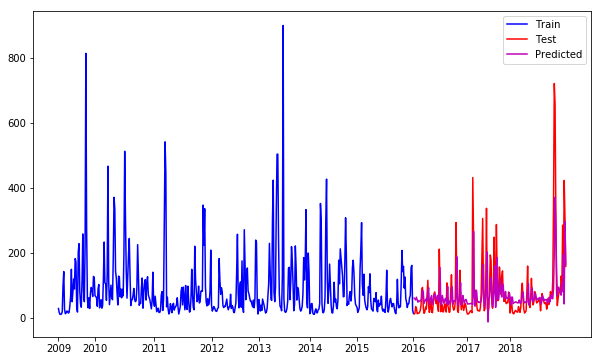

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(sunnyside.index[:train_size], sunnyside['Sunnyside-2'][:train_size], 'b-', label='Train')
ax.plot(sunnyside.index[train_size:train_size+test_size], 
        sunnyside['Sunnyside-2'][train_size:train_size+test_size], 'r-', label='Test')
ax.plot(sunnyside.index[train_size:train_size+test_size], 
        sunnyside['Predictions'][train_size:train_size+test_size], 'm-', label='Predicted')
plt.xticks(years.index, years)
plt.legend()
plt.show();

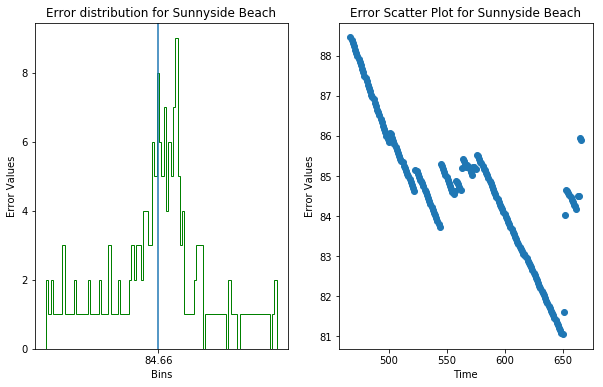

In [33]:
#Plot Errors in a histogram
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(sunnyside['Errors'][train_size:train_size+test_size].values,bins=100,histtype='step',color='green')
ax[0].axvline(sunnyside['Errors'][train_size:train_size+test_size].values.mean())
ax[0].set(xlabel='Bins', ylabel='Error Values', title='Error distribution for Sunnyside Beach', 
          xticks=[sunnyside['Errors'][train_size:train_size+test_size].values.mean()])
ax[1].plot(sunnyside['Errors'][train_size:train_size+test_size].index, 
           sunnyside['Errors'][train_size:train_size+test_size].values,'o')
ax[1].set(xlabel='Time', ylabel='Error Values', title='Error Scatter Plot for Sunnyside Beach');

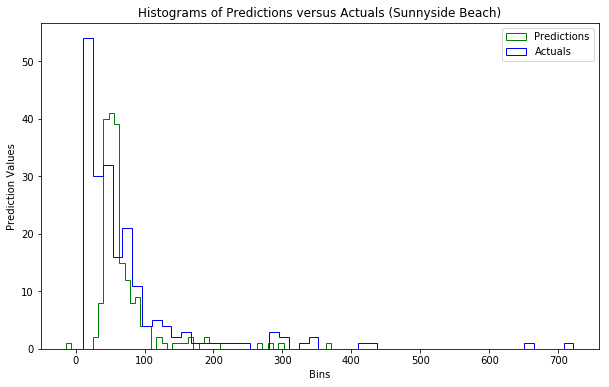

In [37]:
#Plot Predictions in a histogram
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.hist(sunnyside['Predictions'][train_size:train_size+test_size].values,bins=50,histtype='step',
        color='green',label='Predictions')
ax.hist(sunnyside['Sunnyside-2'][train_size:train_size+test_size].values,bins=50,histtype='step',
        color='blue',label='Actuals')
ax.set(xlabel='Bins', ylabel='Prediction Values', 
       title='Histograms of Predictions versus Actuals (Sunnyside Beach)')
plt.legend();

In [38]:
centre['Predictions'] = 0
centre['Errors'] = 0

In [39]:
for i in centre.index:
    if centre.loc[i, 'Label'] == 1:
        model = ARIMA(endog=centre['Centre-5'].values,order=(5,1,1)).fit()
        centre.loc[i, 'Predictions'] = model.forecast()[0][0]
        centre.loc[i, 'Errors'] = model.forecast()[1][0]

In [40]:
centre['sampleDate'] = pd.to_datetime(centre['sampleDate'])
years = centre['sampleDate'].dt.year
years = years.drop_duplicates()
years

0      2009
48     2010
125    2011
201    2012
263    2013
330    2014
392    2015
465    2016
537    2017
593    2018
Name: sampleDate, dtype: int64

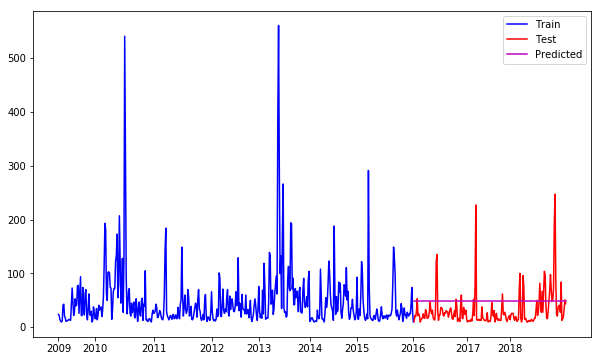

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(centre.index[:train_size], centre['Centre-5'][:train_size], 'b-', label='Train')
ax.plot(centre.index[train_size:train_size+test_size], 
        centre['Centre-5'][train_size:train_size+test_size], 'r-', label='Test')
ax.plot(centre.index[train_size:train_size+test_size], 
        centre['Predictions'][train_size:train_size+test_size], 'm-', label='Predicted')
plt.xticks(years.index, years)
plt.legend()
plt.show();

# Step 5: ARIMA Model Test Results 

In [ ]:
rmse = np.sqrt(mean_squared_error(sunnyside['Sunnyside-2'][train_size:train_size+test_size],
                                  sunnyside['Predictions'][train_size:train_size+test_size]))
rmse